In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from skimage.feature import canny
import Placer as Pl

Загружаем датасет

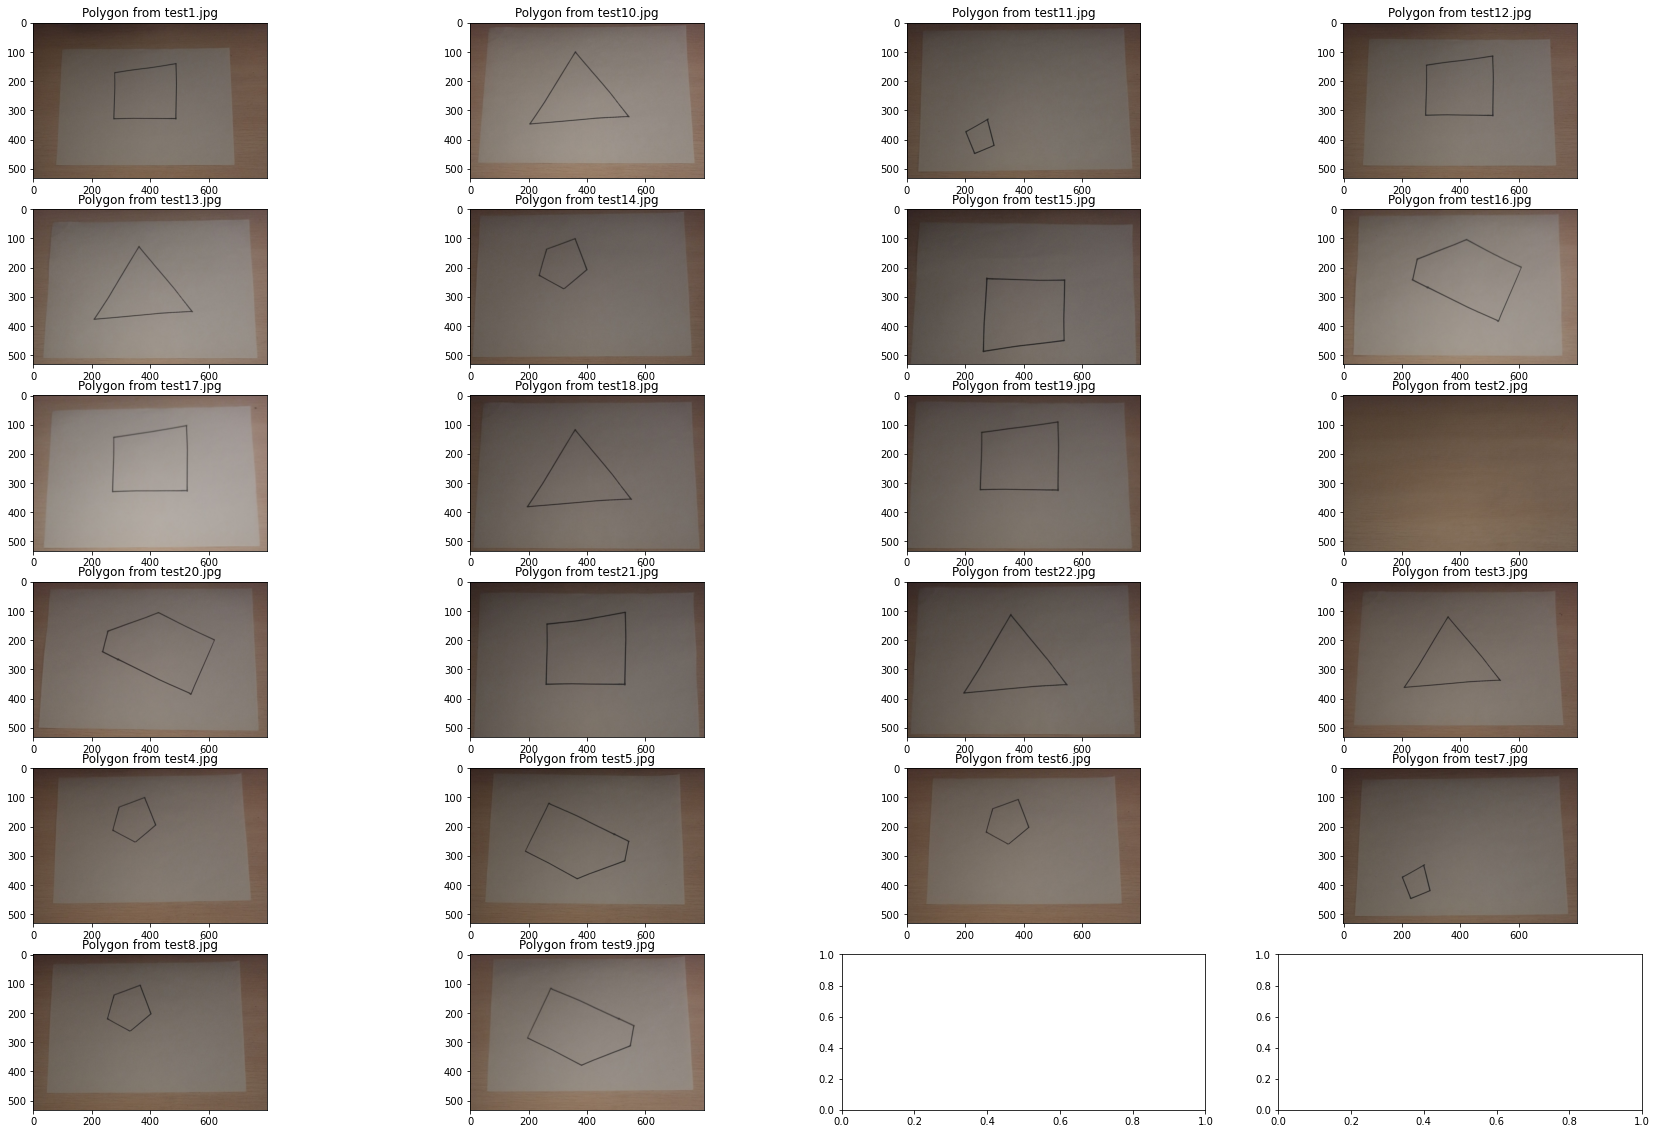

In [2]:
dataset = Pl.get_images('data/')
# константы для разбиения фотографий на две половины (используются фотографии размером 1065х800)
midline = 532
height = 1065
width = 800

fig_up, ax_up = plt.subplots(6, 4, figsize=(30, 20))

for i, (image, name) in enumerate(dataset):
    polygon = image[0:midline, 0:width]
    
    ax_up[i // 4][i % 4].set_title(f'Polygon from {name}')
    ax_up[i // 4][i % 4].imshow(cv2.cvtColor(polygon, cv2.COLOR_BGR2RGB))

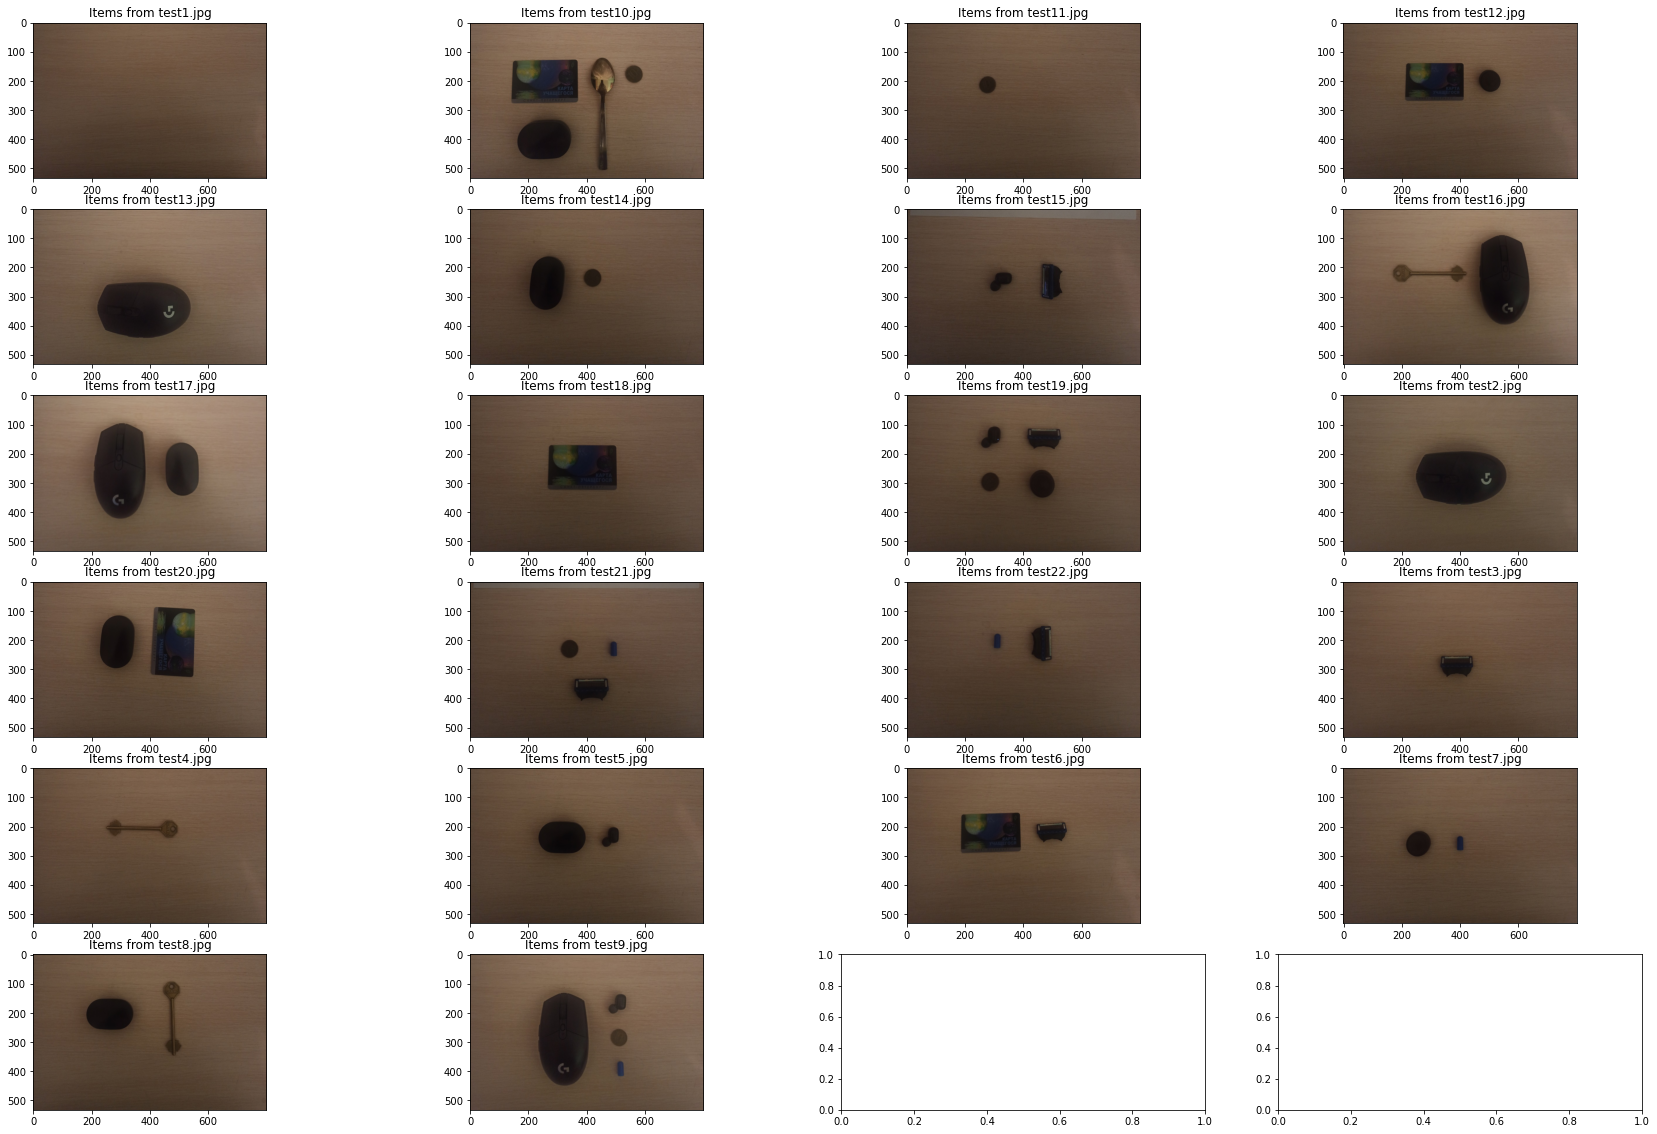

In [3]:
fig_down, ax_down = plt.subplots(6, 4, figsize=(30, 20))
for i, (image, name) in enumerate(dataset):
    items = image[midline:height, 0:width]
    
    ax_down[i // 4][i % 4].set_title(f'Items from {name}')
    ax_down[i // 4][i % 4].imshow(cv2.cvtColor(items, cv2.COLOR_BGR2RGB))

Получим контуры многоугольника и предметов

In [4]:
# списки для контуров, полученных из датасета
poly_contours_from_data = []
items_contours_from_data = []

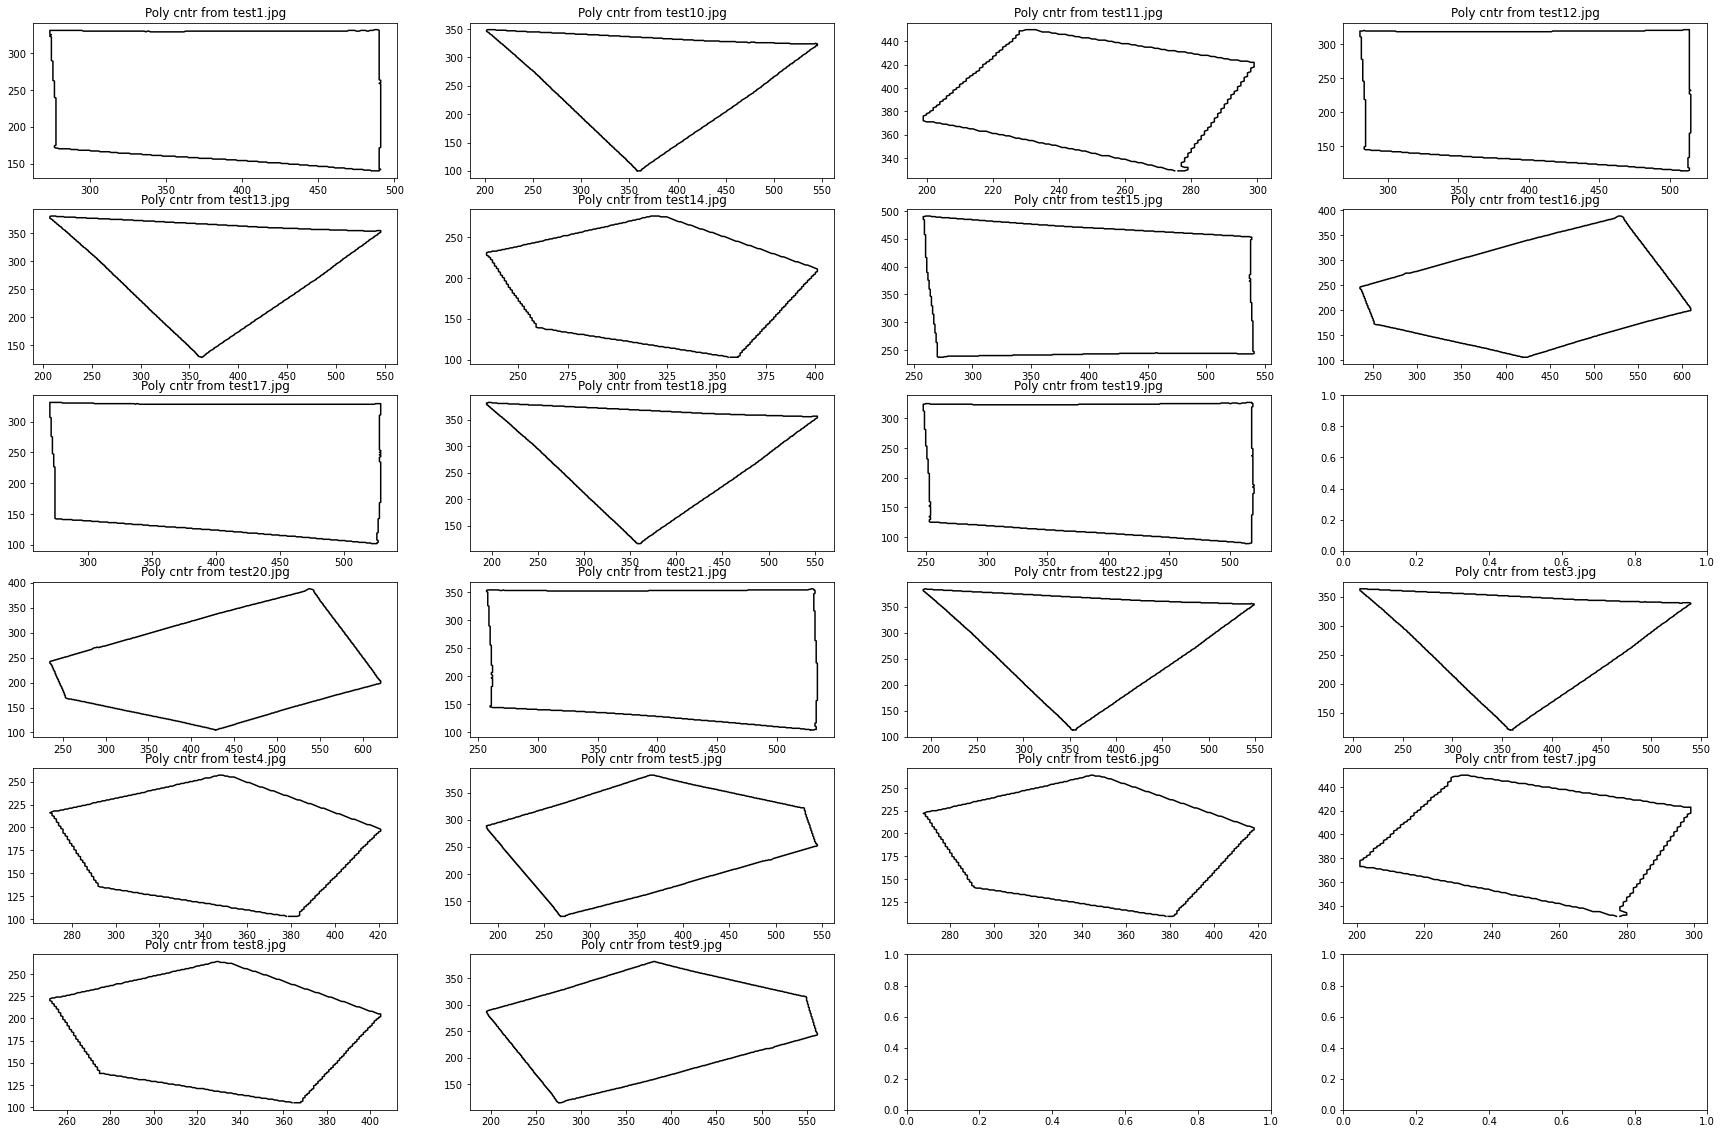

In [5]:
fig_poly, ax_poly = plt.subplots(6, 4, figsize=(30, 20))

for i, (image, name) in enumerate(dataset):
    polygon = image[0:midline, 0:width]
    contour = Pl.get_contour_polygon(polygon)
    poly_contours_from_data.append(contour)
    if len(contour) == 0:
        continue
    
    ax_poly[i // 4][i % 4].set_title(f'Poly cntr from {name}')
    ax_poly[i // 4][i % 4].plot(contour[:, 0][:, 0], contour[:, 0][:, 1], color='black')

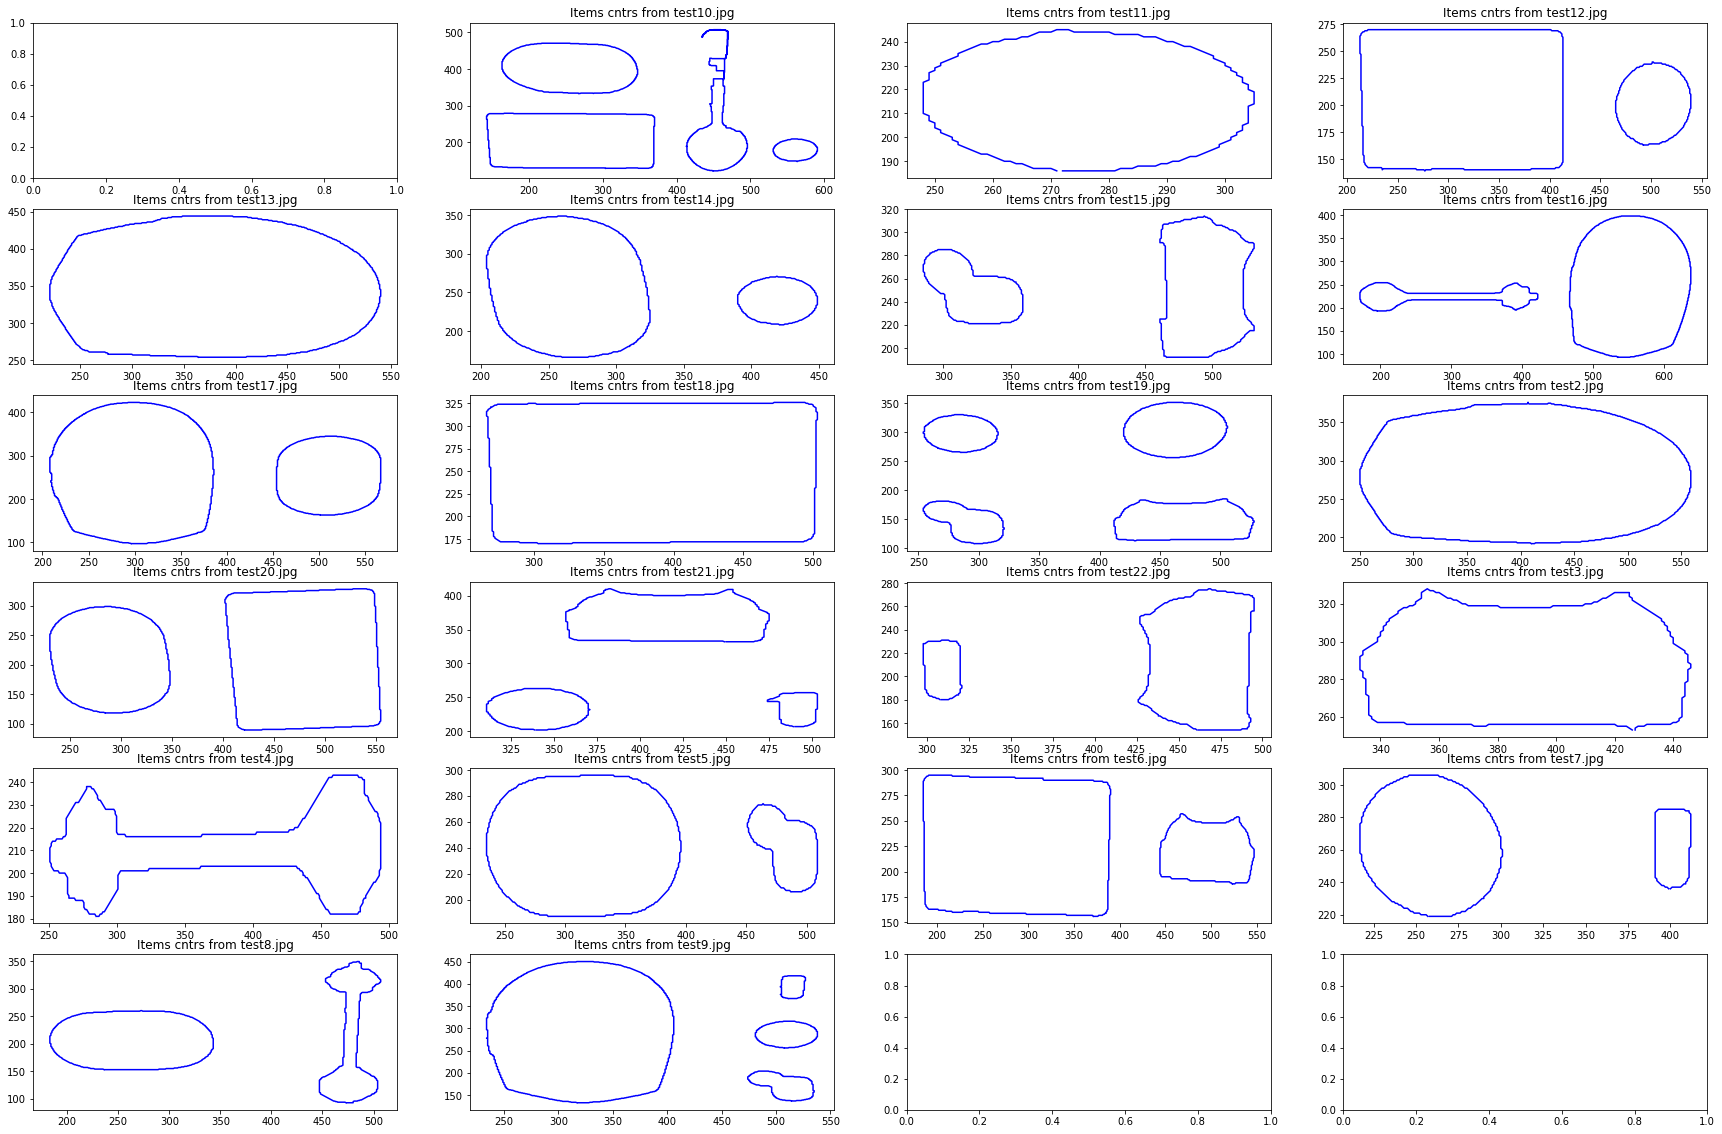

In [6]:
fig_items, ax_items = plt.subplots(6, 4, figsize=(30, 20))
for i, (image, name) in enumerate(dataset):
    items = image[midline:height, 0:width]
    contours = Pl.get_contours_items(items)
    items_contours_from_data.append(contours)
    if len(contours) == 0:
        continue
    
    ax_items[i // 4][i % 4].set_title(f'Items cntrs from {name}')
    for c in contours:
        ax_items[i // 4][i % 4].plot(c[:, 0][:, 0], c[:, 0][:, 1], color='blue')

Обработаем датасет функцией placing, которая постарается определить, смогут ли предметы поместиться во многоугольник. Суть работы функции placing - обход многоугольника с выбранным шагом: в каждой точке обхода также идёт проверка на вместимость в полигон с помощью поворота на выбранный угол

In [7]:
# кол-во правильно обработанных тестов
correct_output = 0
# таблица с ожидаемыми значениями
table = pd.read_csv('expected.csv')
table

,name,expected
0,1.jpg,0
1,10.jpg,0
2,11.jpg,1
3,12.jpg,1
4,13.jpg,0
5,14.jpg,0
6,15.jpg,1
7,16.jpg,0
8,17.jpg,0
9,18.jpg,0


In [8]:
%%time
# список ответов плейсера
placer_answers = []
# размер фотографий, нужен для построения изображения с масками в ходе работы функции placing
size = (height, width)
for i in range(len(dataset)):
    expected = table.loc[i, 'expected']
    result = Pl.placing(size, items_contours_from_data[i], poly_contours_from_data[i])
    correct_output += (result == expected)
    placer_answers.append(int(result))

CPU times: total: 27.6 s
Wall time: 27.8 s


Итоговая таблица

In [9]:
result_table = table.join(pd.DataFrame(np.array(placer_answers), columns=['real']))
result_table.to_csv('result_table.csv')

Правильные ответы алгоритма

In [10]:
result_table[result_table['expected'] == result_table['real']]

,name,expected,real
0,1.jpg,0,0
1,10.jpg,0,0
2,11.jpg,1,1
4,13.jpg,0,0
5,14.jpg,0,0
6,15.jpg,1,1
7,16.jpg,0,0
8,17.jpg,0,0
9,18.jpg,0,0
10,19.jpg,1,1


Ложные ответы алгоритма

In [11]:
result_table[result_table['expected'] != result_table['real']]

,name,expected,real
3,12.jpg,1,0
12,20.jpg,1,0
21,9.jpg,1,0


Результат работы плейсера (помимо точности, посчитаем также метрики Recall (доля объектов положительного класса, найденных алгоритмом, из всех объектов положительного класса) и Precision (доля объектов, названными положительными и при этом действительно являющимися положительными))

In [12]:
TP = result_table[(result_table['expected'] == 1) & (result_table['real'] == 1)].shape[0]
FP = result_table[(result_table['expected'] == 0) & (result_table['real'] == 1)].shape[0]
FN = result_table[(result_table['expected'] == 1) & (result_table['real'] == 0)].shape[0]

print(f'Точность на имеющихся тестах {round(correct_output / len(dataset) * 100, 2)}%')
print(f'Recall на имеющихся тестах {round(TP/(TP+FN), 2)}')
print(f'Precision на имеющихся тестах {round(TP/(TP+FP), 2)}')

Точность на имеющихся тестах 86.36%
Recall на имеющихся тестах 0.7
Precision на имеющихся тестах 1.0


На данной итерации было чуть улучшено определение контуров предметов (были подобраны более подходящие параметры для препроцессинга) и был реализован довольно простой, переборный алгоритм размещения предметов с шагом перебора. Данный алгоритм не допускает ложноположительных ответов, однако встречаются ложноотрицательные. Связано это с тем, что пока не реализовано разумное расположение объектов, поэтому при поочередном размещении, большие по площади объекты "съедают" пространство таким образом, что следующие уже не влезают, хотя место для них должно быть. Это проявляется на тестах, где предметы в теории должны влезать во многоугольник практически вплотную друг к другу. Также, он работает не идеально быстро, в данной итерации было затрачено 28 секунд на 22 теста: в среднем 1.27 секунды на тест. Планируется улучшить нынешний алгоритм в целях устранения данных недостатков: например, ввести какую-нибудь метрику для определения наилучшей позиции для объекта. 